# Tutorial week 3

## GLM recap, HRF Basis Functions, Sampling frequencies and statistics.

### imports

In [2]:
import numpy as np
import scipy as sp
import nibabel as nb

import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline 

import os

/Users/knapen/anaconda2/envs/analysis/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
## make sure that these paths match the locations where you downloaded the files! 
# note that loading the data may take a while (approx 10 seconds on my computer, but this depends on your hard drive)
base_dir = '/Users/knapen/Documents/edu/VU/courses/BrainImaging_16/course/data/'

## Outline of the data and analyses
We're going to use data from a visual experiment. Visual stimuli were shown to the left or right of fixation, so these left and right visual stimulation events are going to be the basis of our regressors. Just like last week, we're going to convolve these events with the HRF, and analyze data using the GLM.

For our data, we're going to use the time series of two voxels: one that responds strongly to left visual stimuli, and another that responds really strongly to right visual stimuli. These voxels' data give us an opportunity to perform our analyses while we already know what should come out, increasing clarity. 

## Take Home:

What do you need to understand at the end of this week's practical?
- What are $\beta$ values: scaling factors of explicit expectations we model (explanatory variable or regressor).
- We use the GLM to calculate these $\beta$ values, while assuming 
    - a certain shape of HRF
    - independent samples (0 autocorrelation) of the data
- These assumptions are not always met, so we have ways of correcting for errors in our assumptions:
    - we can flexibly fit the shape and timing of the HRF (*cf.* basis functions, time-derivative)
    - we can correct the GLM for autocorrelation of the timeseries (*cf.* Autocorrelation correction, prewhitening)
- To compare $\beta$ values we need to calculate statistics (T statistics), to see whether differences in $\beta$ values are significant (p values).

### import full data: run this cell only if your computer has enough memory. 

In [4]:
# run this cell only if your computer has enough memory. 
# if not, go on to the next cell.
functional_file = nb.load(os.path.join(base_dir, '2DEPI_MB3','2DEPI_MB3.nii.gz'))
functional_data = functional_file.get_data()
zstat7_file = nb.load(os.path.join(base_dir, '2DEPI_MB3','2DEPI_MB3.feat/stats/zstat7.nii.gz'))
zstat7_data = zstat7_file.get_data()

left_voxel_timecourse, right_voxel_timecourse = functional_data[zstat7_data==zstat7_data.max(),:], functional_data[zstat7_data==zstat7_data.min(),:]
np.save(os.path.join(base_dir, 'max_voxel_signals.npy'), np.array([left_voxel_timecourse, right_voxel_timecourse]))

left_voxel_timecourse_Z = (left_voxel_timecourse-left_voxel_timecourse.mean()) / left_voxel_timecourse.std()
right_voxel_timecourse_Z = (right_voxel_timecourse-right_voxel_timecourse.mean()) / right_voxel_timecourse.std()

### import less data: run this cell after downloading the max_voxel_signals.npy file from blackboard

In [5]:
left_voxel_timecourse, right_voxel_timecourse = np.load(os.path.join(base_dir, 'max_voxel_signals.npy'))
# we take data out of the functional data, and normalize these time-courses.
left_voxel_timecourse_Z = (left_voxel_timecourse-left_voxel_timecourse.mean()) / left_voxel_timecourse.std()
right_voxel_timecourse_Z = (right_voxel_timecourse-right_voxel_timecourse.mean()) / right_voxel_timecourse.std()

### load the events that comprised the experiments

In [6]:
# this loads the events separately for left and right stimulus presentations
L_events, R_events = [np.concatenate([np.loadtxt(os.path.join(base_dir, '2DEPI_MB3', '%s_%s.txt'%(c, s)))[:,0] for c in ['CW','CCW']]) for s in ['L','R']]

## Intermission: Basis functions
We've been using the canonical HRF to build our models in the previous exercises, and in these exercises you saw that this was a very efficient way of analyzing fMRI data: you only need a single regressor to capture the response magnitude to a single condition or type of event. But you also saw that using this HRF can be pretty restrictive (for example when your subject has a slow HRF shape). Luckily there are more advanced ways of describing the BOLD response, that can be used to make one's beta weight estimates more flexible. These methods revolve around the concept of basis functions. The idea here is that we use not one regressor but multiple regressors, which are uncorrelated, to describe the response to a single type of event, or condition. The combination of these multiple regressors gives us flexibility regarding the timing, and shape of the response. We say that these basis functions span a space of possible HRF shapes. The penalty of using more extended basis function sets is that you need more regressors in your design matrix, and in order to be able to fit this, you need more timepoints in your data. 

Different basis function sets exist; they can be based on sines and cosines (a Fourier basis set), on normal distributions (Gaussian functions), and even on stick functions (which is called a Finite Impulse Response basis function set). But the most often used set is that, you guessed it, of Gamma functions like the one we're already used to. One practical example, also used to circumvent the pre-processing step of slice-time correction (which you will hear about later), is that of the addition of the time-derivative of the Gamma-shaped HRF response. That looks like this.

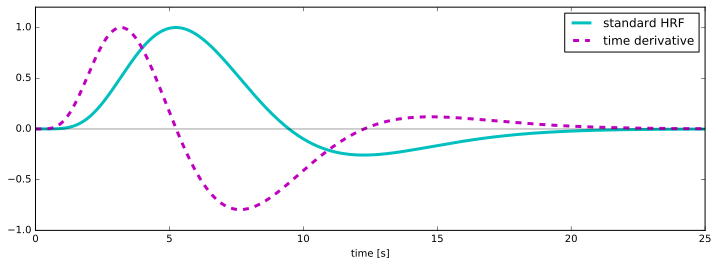

In [7]:
# start out with a design matrix and convolution at 40 Hz

model_sample_freq = 40
hrf_duration = 25

def double_gamma(x, a1 = 6, a2 = 12, b1 = 0.9, b2 = 0.9, c = 0.35):
	d1 = a1 * b1
	d2 = a2 * b2
	return np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])

timepoints_to_evaluate = np.linspace(0,hrf_duration,hrf_duration*model_sample_freq)
hrf = double_gamma(timepoints_to_evaluate, a1 = 6, a2 = 12, b1 = 0.9, b2 = 0.9, c = 0.35)
hrf /= hrf.max()

hrf_dt = np.r_[0,np.diff(hrf)]
hrf_dt /= hrf_dt.max()
f = plt.figure(figsize = (12,4))
plt.plot(timepoints_to_evaluate, hrf, 'c', lw = 3)
plt.plot(timepoints_to_evaluate, hrf_dt, 'm--', lw = 3)
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.gca().set_ylim([-1,1.2])
plt.xlabel('time [s]')
plt.legend(['standard HRF', 'time derivative'])

What does this do? Look below, where we plot the standard HRF, but we add different 'amounts' of its time-derivative. You should see that this changes the time-to-peak of the HRF, and can give it an initial dip. Allowing the time-derivative to change the overall fitted shape of the BOLD response can give more efficient results in terms of final $\beta$ weights. 

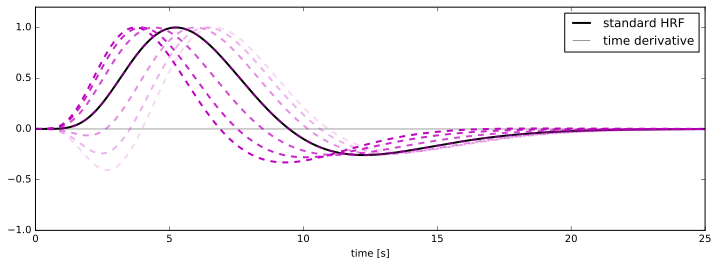

In [8]:
f = plt.figure(figsize = (12,4))
plt.plot(timepoints_to_evaluate, hrf, 'k', lw = 2.0)
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

for x, alp in zip(np.linspace(-1,1,7), np.linspace(0.15,1.0,7)):
    new_hrf = hrf + x * hrf_dt
    new_hrf /= new_hrf.max()
    plt.plot(timepoints_to_evaluate, new_hrf, 'm--', alpha = alp, lw = 2.0)

plt.gca().set_ylim([-1,1.2])
plt.xlabel('time [s]')
plt.legend(['standard HRF', 'time derivative'])

**For the exercises:**
In practice, if we want to use the addition of the time derivative, we create a separate regressor for this time-derivative, convolving the neural signals with the time-derivative as an HRF. This then goes into the design matrix as if it were an actual, normal regressor. However, as FSL does it, the beta weight for the time-derivative regressor is not used for the calculation of statistics. 
    

## Back to the experiment at hand
What do we do with the events? They're not defined at 40 Hz or anything!
We will have to create a 'signal' that contains these events in 40 Hz samples. The stimulus presentations lasted ~1 s.

xyzt units: (2.0, 2.0, 2.0, 0.9444766)
run lasted  424.8  seconds 


(-0.1, 1.1)

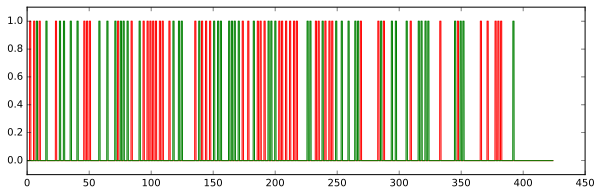

In [9]:
# We have to find out how long our run took
# comment these lines if you don't have functional_data loaded
xyzt = functional_file.header.get_zooms()
print 'xyzt units:', xyzt
# so, our TR was:
TR = xyzt[-1]
run_duration_in_sec = TR * functional_data.shape[-1]

# if you don't have the functional file loaded:
TR = 0.944
run_duration_in_sec = TR * left_voxel_timecourse_Z.shape[1]
print 'run lasted ', run_duration_in_sec, ' seconds '

# that's also a number of 40 Hz samples:
run_duration_in_samples = np.int(model_sample_freq * run_duration_in_sec)
empty_signal = np.zeros(run_duration_in_samples)

# create separate signals for right and left stimuli
neural_signal_1 = np.copy(empty_signal)
neural_signal_2 = np.copy(empty_signal)
# events are still coded in seconds, and duration was 40 samples, or 1 s
# the following calculation allows us to define everything in samples. 
# check whether you get it!
for LE in L_events:
    neural_signal_1[np.int(LE*model_sample_freq):np.int(LE*model_sample_freq)+model_sample_freq] = 1.0
for RE in R_events:
    neural_signal_2[np.int(RE*model_sample_freq):np.int(RE*model_sample_freq)+model_sample_freq] = 1.0

# and we plot the 'neural signals', with x axis representing time in seconds.
f = plt.figure(figsize = (10,3))
plt.plot(np.linspace(0,neural_signal_1.shape[0]/model_sample_freq, neural_signal_1.shape[0]), neural_signal_1, 'r')
plt.plot(np.linspace(0,neural_signal_2.shape[0]/model_sample_freq, neural_signal_2.shape[0]), neural_signal_2, 'g')
plt.gca().set_ylim([-0.1,1.1])

### Convolution

SO, back to our experiment and actual data. The events in the text files gave us our neural signals, sampled at 40 Hz. We want to convolve at this high frequency so that we create nice-looking regressors. If you record data at 2s TR, it becomes prohibitive to create an HRF sampled at 2s and also perform convolution in that time-resolution, so one upsamples the 'neural signals' to a higher frequency for the convolution and then downsamples later, as we do here too.

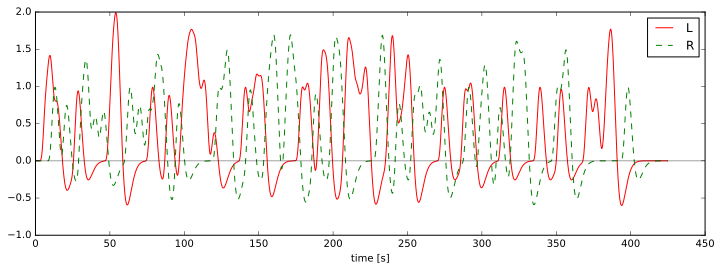

In [10]:
model_BOLD_timecourse_1 = np.convolve(neural_signal_1, hrf, 'full')[:neural_signal_1.shape[0]] / model_sample_freq
model_BOLD_timecourse_2 = np.convolve(neural_signal_2, hrf, 'full')[:neural_signal_2.shape[0]] / model_sample_freq

f = plt.figure(figsize = (12,4))
plt.plot(np.linspace(0,run_duration_in_sec, run_duration_in_samples), model_BOLD_timecourse_1, 'r')
plt.plot(np.linspace(0,run_duration_in_sec, run_duration_in_samples), model_BOLD_timecourse_2, 'g--')
# plt.gca().set_ylim([-30,90])
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

plt.xlabel('time [s]')
plt.legend(['L', 'R'])

This means we have model regressors at a very high time resolution (40Hz), and we need to make sure that we go to the sampling frequency of our data, which was a little higher than 1Hz. 

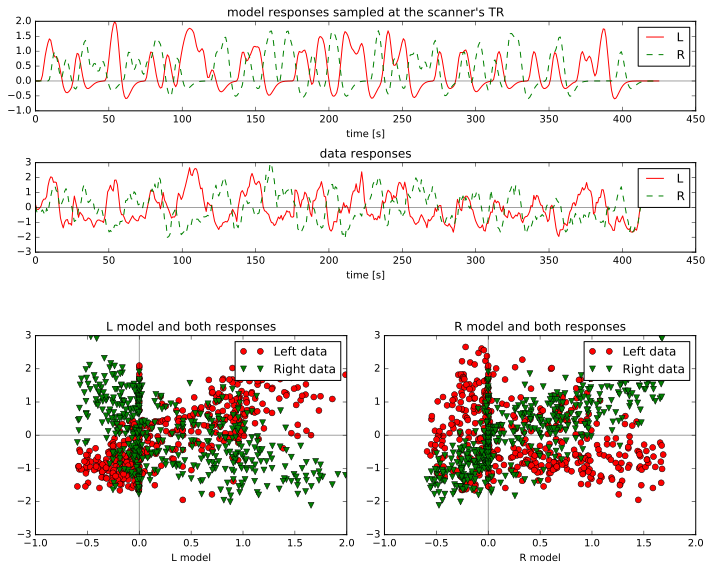

In [11]:
# No we have to find what points in the high-resolution model correspond to actual scanner measurement times
samples_per_TR = model_sample_freq * TR
TR_indices = np.array([int(x * samples_per_TR) for x in np.arange(0, left_voxel_timecourse_Z.shape[-1])])

L_model_data_at_TRs = model_BOLD_timecourse_1[TR_indices]
R_model_data_at_TRs = model_BOLD_timecourse_2[TR_indices]

f = plt.figure(figsize = (10,8))
s = f.add_subplot(411)
s.set_title('model responses sampled at the scanner\'s TR')
plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), L_model_data_at_TRs, 'r')
plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), R_model_data_at_TRs, 'g--')
# plt.gca().set_ylim([-30,90])
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.xlabel('time [s]')
plt.legend(['L', 'R'])

s = f.add_subplot(412)
s.set_title('data responses')
plt.plot(np.linspace(0,run_duration_in_sec, left_voxel_timecourse_Z.shape[-1]), left_voxel_timecourse_Z[0], 'r')
plt.plot(np.linspace(0,run_duration_in_sec, left_voxel_timecourse_Z.shape[-1]), right_voxel_timecourse_Z[0], 'g--')
# plt.gca().set_ylim([30,60])
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.xlabel('time [s]')
plt.legend(['L', 'R'])

s = f.add_subplot(223)
s.set_title('L model and both responses')
plt.plot(L_model_data_at_TRs, left_voxel_timecourse_Z[0], 'ro', alpha = 0.25)
plt.plot(L_model_data_at_TRs, right_voxel_timecourse_Z[0], 'gv', alpha = 0.25)
# plt.gca().set_ylim([30,60])
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.axvline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.xlabel('L model')
plt.legend(['Left data', 'Right data'])

s = f.add_subplot(224)
s.set_title('R model and both responses')
plt.plot(R_model_data_at_TRs, left_voxel_timecourse_Z[0], 'ro', alpha = 0.25)
plt.plot(R_model_data_at_TRs, right_voxel_timecourse_Z[0], 'gv', alpha = 0.25)
# plt.gca().set_ylim([30,60])
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.axvline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.xlabel('R model')
plt.legend(['Left data', 'Right data'])

plt.tight_layout()

## GLM and Beta values

This is the first time we use actual data to calculate beta values - we're going to do an actual fit on data. Very similar to the earlier analysis of simulated data, this here is the basic analysis such as the one FSL is doing in the background.

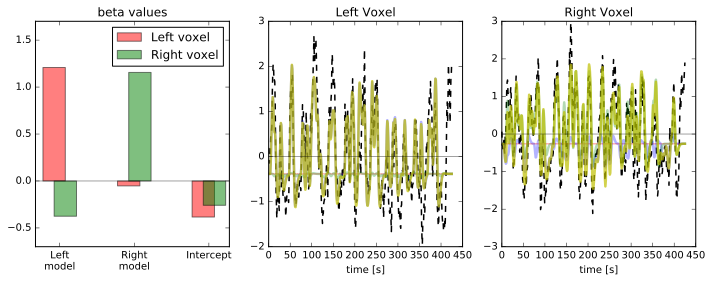

In [12]:
# we first have to create a design matrix, by putting the different expectations together, and
# again adding the ones for fitting the intercept.
design_matrix = np.array([L_model_data_at_TRs, R_model_data_at_TRs, np.ones(R_model_data_at_TRs.shape[0])])
fmri_data = np.array([left_voxel_timecourse_Z,right_voxel_timecourse_Z]).squeeze()

# first, we perform our analysis on the multimodal voxel.
# we again use the linear regression function
betas, _sse, _r, _svs = np.linalg.lstsq(design_matrix.T, fmri_data.T )

left_residuals = np.squeeze(left_voxel_timecourse_Z - (L_model_data_at_TRs*betas[0,0] + R_model_data_at_TRs*betas[1,0] + betas[2,0]))
right_residuals = np.squeeze(right_voxel_timecourse_Z - (L_model_data_at_TRs*betas[0,1] + R_model_data_at_TRs*betas[1,1] + betas[2,1]))

# now we also want to plot these
fig = plt.figure(figsize = (10,4))
# first, a bar chart of the beta values
s = fig.add_subplot(131)

plt.title('beta values')

plt.bar([0,1,2], betas[:,0], color = 'r', width = 0.3, alpha = 0.5)
plt.bar([0.15,1.15,2.15], betas[:,1], color = 'g',width = 0.3, alpha = 0.5)
plt.legend(['Left voxel', 'Right voxel'])
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

s.set_xticks([0.225,1.225,2.225])
s.set_xticklabels(['Left\nmodel', 'Right\nmodel', 'Intercept'])
s.set_xlim([-0.1,2.5])
s.set_ylim([-0.7,1.7])

ax = fig.add_subplot(132)

plt.title('Left Voxel')
plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
         left_voxel_timecourse_Z.squeeze(), 'k--', lw = 1.5, alpha = 1.0)

plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
        np.ones(functional_data.shape[-1])*betas[2,0], lw = 1.5, color = 'r', alpha = 0.3)

plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
         L_model_data_at_TRs*betas[0,0] + betas[2,0], lw = 2.5, color = 'b', alpha = 0.3)

plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
         R_model_data_at_TRs*betas[1,0] + betas[2,0], lw = 2.5, color = 'g', alpha = 0.3)

plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
          L_model_data_at_TRs*betas[0,0] + R_model_data_at_TRs*betas[1,0] + betas[2,0], lw = 2.5, color = 'y', alpha = 0.7)

plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.xlabel('time [s]')

ax = fig.add_subplot(133)
plt.title('Right Voxel')
plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
         right_voxel_timecourse_Z.squeeze(), 'k--', lw = 1.5, alpha = 1.0)

plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
        np.ones(functional_data.shape[-1])*betas[2,1], lw = 1.5, color = 'r', alpha = 0.3)

plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
         L_model_data_at_TRs*betas[0,1] + betas[2,1], lw = 2.5, color = 'b', alpha = 0.3)

plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
         R_model_data_at_TRs*betas[1,1] + betas[2,1], lw = 2.5, color = 'g', alpha = 0.3)

plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), 
          L_model_data_at_TRs*betas[0,1] + R_model_data_at_TRs*betas[1,1] + betas[2,1], lw = 2.5, color = 'y', alpha = 0.7)


plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

plt.xlabel('time [s]')
plt.tight_layout()

## Autocorrelation and its correction

But there is an important way in which our data do not follow a major assumptions of the GLM analysis we've used. That is, the General Linear Model assumes that all samples are independently drawn. That is, in the regression analysis we're running on timepoints, the assumption is that all of these timepoints have nothing to do with one another. But as you see immediately when looking at the signals, neigboring timepoints are correlated with one another. This influence from timepoint to timepoint is called signal autocorrelation.

This means that the data do not accord with the assumptions of the methods used, and this disparity may influence our statistical results. Thus, it is a standard option to try to correct for the fact that neighboring timepoints are not independent. The most often-used method to do this is by **prewhitening**. This term refers to the fact that a totally uncorrelated timesignal has a flat powerspectrum, which is called *white*. The goal of prewhitening is to modify the fMRI signal such that it becomes more like an uncorrelated (white noise) signal. First, we'll illustrate a bit of Fourier analysis - but don't worry - this is only to boost your intuition.

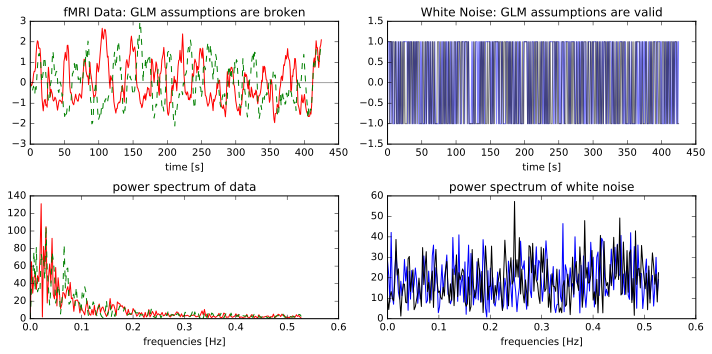

In [13]:
# first, we calculate a bit of stuff about the data.
n_freqs = np.int(left_voxel_timecourse_Z.shape[1] / 2)
frequencies_in_signal = np.fft.fftfreq(left_voxel_timecourse_Z.shape[1], TR)

# then, we compute the power spectra of the fmri data
ps_1 = np.abs(np.fft.fft(left_voxel_timecourse_Z[0])[:n_freqs])
ps_2 = np.abs(np.fft.fft(right_voxel_timecourse_Z[0])[:n_freqs])

# then, we create white noise signals
noise_signal_1 = np.random.randint(0,2,size = left_voxel_timecourse_Z.shape[1])-0.5
noise_signal_2 = np.random.randint(0,2,size = left_voxel_timecourse_Z.shape[1])-0.5
noise_signal_1, noise_signal_2 = noise_signal_1/np.std(noise_signal_1), noise_signal_2/np.std(noise_signal_2)

# and calculate their power spectra
ps_wn_1 = np.abs(np.fft.fft(noise_signal_1)[:n_freqs])
ps_wn_2 = np.abs(np.fft.fft(noise_signal_2)[:n_freqs])

# now we also want to plot these
fig = plt.figure(figsize = (10,5))
# first, a bar chart of the beta values
s = fig.add_subplot(221)

plt.title('fMRI Data: GLM assumptions are broken')
plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), left_voxel_timecourse_Z[0], 'r')
plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), right_voxel_timecourse_Z[0], 'g--')
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

plt.xlabel('time [s]')
s = fig.add_subplot(222)

plt.title('White Noise: GLM assumptions are valid')

plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), noise_signal_1, 'b', alpha = 0.5)
plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), noise_signal_2, 'k', alpha = 0.5)

plt.xlabel('time [s]')

s = fig.add_subplot(223)

plt.title('power spectrum of data')
plt.plot(frequencies_in_signal[:n_freqs], ps_1, 'r')
plt.plot(frequencies_in_signal[:n_freqs], ps_2, 'g--')
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

plt.xlabel('frequencies [Hz]')
s = fig.add_subplot(224)

plt.title('power spectrum of white noise')

plt.plot(frequencies_in_signal[:n_freqs], ps_wn_1, 'b')
plt.plot(frequencies_in_signal[:n_freqs], ps_wn_2, 'k')

plt.xlabel('frequencies [Hz]')

plt.tight_layout()

We're not going to go into advanced signal analysis, but let's try to notice a couple of things about the differences between the data and white noise. Like many biological signals, the fMRI data has what's called a 1/$f$ frequency pattern, where there is more 'power' at lower frequencies, and the power drops off as frequencies increase. This means that this type of signal is dominated by slower signals. Another name for this type of 1/$f$ signal is **'pink'** noise. The **white** noise in the right column on the other hand, is relatively dominated by faster signals at higher frequencies, giving it a flat power spectrum. 
What does this mean for the autocorrelation? Let's describe the autocorrelation structure of our actual data, and its residuals.

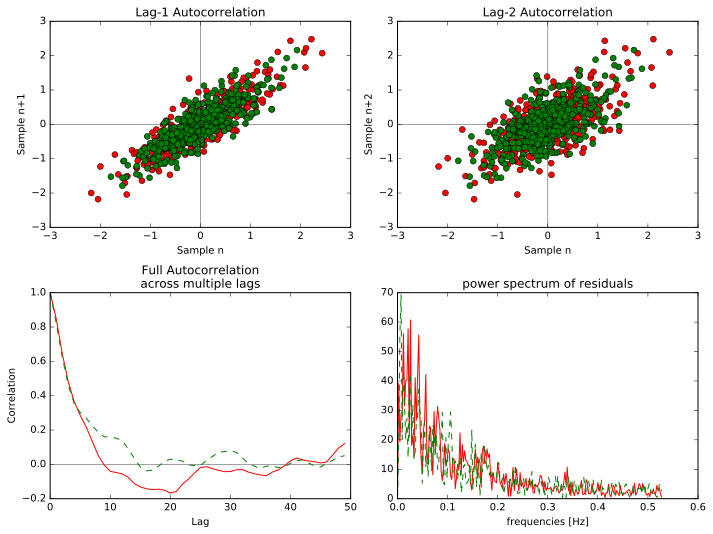

In [14]:
# at this point, the GLM has already been fit (see above)
# The fitted timecourses, as plotted above:
fitted_fmri_data = np.array([L_model_data_at_TRs*betas[0,0] + R_model_data_at_TRs*betas[1,0] + betas[2,0], 
          L_model_data_at_TRs*betas[0,1] + R_model_data_at_TRs*betas[1,1] + betas[2,1]])

# we are interested in the autocorrelation structure of the residuals
residuals = fmri_data - fitted_fmri_data

# then, we compute the power spectra of the fmri data
rps_1 = np.abs(np.fft.fft(residuals[0])[:n_freqs])
rps_2 = np.abs(np.fft.fft(residuals[1])[:n_freqs])

# let's see how one sample of our signal influences the other:

f = plt.figure(figsize = (10,7.5))
s = f.add_subplot(221)

plt.title('Lag-1 Autocorrelation')
plt.plot(residuals[0,:-1], residuals[0,1:], 'ro', alpha = 0.25)
plt.plot(residuals[1,:-1], residuals[1,1:], 'go', alpha = 0.25)
plt.xlabel('Sample n')
plt.ylabel('Sample n+1')
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.axvline(0, c = 'k', linewidth = 0.75, alpha = 0.5)


s = f.add_subplot(222)

plt.title('Lag-2 Autocorrelation')
plt.plot(residuals[0,:-2], residuals[0,2:], 'ro', alpha = 0.25)
plt.plot(residuals[1,:-2], residuals[1,2:], 'go', alpha = 0.25)
plt.xlabel('Sample n')
plt.ylabel('Sample n+2')
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.axvline(0, c = 'k', linewidth = 0.75, alpha = 0.5)


def autocorr(x):
    result = np.correlate(x, x, 'full')
    return result[result.size/2:]

ac1,ac2 = autocorr(residuals[0]), autocorr(residuals[1])

s = f.add_subplot(223)
plt.title('Full Autocorrelation\nacross multiple lags')

plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
plt.plot(ac1[:50]/ac1[0], 'r')
plt.plot(ac2[:50]/ac2[0], 'g--')

plt.xlabel('Lag')
plt.ylabel('Correlation')

s = f.add_subplot(224)

plt.title('power spectrum of residuals')
plt.plot(frequencies_in_signal[:n_freqs], rps_1, 'r')
plt.plot(frequencies_in_signal[:n_freqs], rps_2, 'g--')
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

plt.xlabel('frequencies [Hz]')

plt.tight_layout()

## Correcting for these autocorrelations
As you may have intuited, the slow frequencies' dominance in the actual data causes positive autocorrelation at small lags (in this case, for the first ~10 TRs). This is quite a strong departure from the assumptions of the GLM. There are multiple techniques to overcome this problem. One can for instance 'precolor' the data by smoothing the data's timecourse. This method is not optimal however, as it throws away data. The method of choice nowadays is that of 'prewhitening'. The goal of 'prewhitening' is to make sure that the data become more like white noise. This is usually done in a multi-step way, as follows:

1. we fit a GLM model as we already have. 
2. we then examine (fit) the autocorrelation structure of the residuals, as above
3. we correct the autocorrelation structure of the residuals
4. add the corrected residuals to the 'explained (fitted) signal'
5. re-run the GLM on these corrected, or prewhitened data.

There are many complicated ways of fitting the autocorrelation structure of a signal. Here, we show you how to fit an AR(1) process to the data. This procedure is a bit too complicated to be a part of the exam, but please read through the code and the appropriate sections in the book. It **is** important that you understand why we need to take these steps!

We start out with a fitted GLM, so after step 1 outlined above. Our approach will characterize the  autocorrelation of the residuals and then do the correction and re-run of the GLM at once.
First, we describe the residuals' autocorrelation according to the function $$\epsilon_t = \rho\epsilon_{t-1} + c + \omega_t$$ 
Here, $\rho$ is the autocorrelation parameter, $c$ is a constant (should be near-zero, unless there is drift in the residuals) and $\omega$ is an autocorrelation error term, of which we can find the standard deviation $\sigma$. 


In [15]:
# code for this fit taken from github:
# https://github.com/ndronen/misc/blob/master/python/ar1.py
def fit_AR(ts):
    # Estimate rho
    x = ts[0:-1]
    y = ts[1:]
    p = sp.polyfit(x,y,1)
    rho = p[0]

    # Estimate c
    c = sp.mean(ts)*(1-rho)

    # Estimate the variance from the residuals of the OLS regression.
    yhat = sp.polyval(p,x)
    variance = sp.var(y-yhat)
    sigma = sp.sqrt(variance)

    return rho, c, sigma

fr_1 = fit_AR(residuals[0])
fr_2 = fit_AR(residuals[1])

print 'residuals[0] Autocorr parameter: %2.2f, offset = %2.2f, sigma: %2.2f'% fr_1
print 'residuals[1] Autocorr parameter: %2.2f, offset = %2.2f, sigma: %2.2f'% fr_2

residuals[0] Autocorr parameter: 0.88, offset = 0.00, sigma: 0.34
residuals[1] Autocorr parameter: 0.85, offset = -0.00, sigma: 0.34


The code in the cell below will not be quizzed, but is here for illustration and continuation purposes.

In [16]:
#
# The below code will not be quizzed, but is here for illustration and continuation purposes.
#
# parameters for the creation of the noise variance/covariance matrix from the AR(1) model.

gamma_1 = (fr_1[2]**2 ) / (1.0 - fr_1[0]**2)
gamma_2 = (fr_2[2]**2 ) / (1.0 - fr_2[0]**2)

# we create variance/covariance matrices for each of the residuals
varcov_1 = np.eye(residuals[0].shape[0]) * gamma_1
varcov_2 = np.eye(residuals[1].shape[0]) * gamma_2

# and fill in the values
for i in range(1, residuals[0].shape[0]):
    x, y = np.diag_indices(residuals[0].shape[0])
    varcov_1[x[i:],y[:-i]] = gamma_1 * fr_1[0] ** i
#     varcov_1[y[:-i],x[i:]] = gamma_1 * fr_1[0] ** i

    varcov_2[x[i:],y[:-i]] = gamma_2 * fr_2[0] ** i
#     varcov_2[y[:-i],x[i:]] = gamma_2 * fr_2[0] ** i

# we invert these variance/covariance matrices.
# K_1 = np.matrix(np.linalg.pinv(varcov_1))
# K_2 = np.matrix(np.linalg.pinv(varcov_2))

K_1 = varcov_1
K_2 = varcov_2

# not important to plot these matrices
# f = plt.figure(figsize = (10,4))
# s = plt.subplot(121)
# plt.title('Var/Cov matrix of residual_1')
# plt.imshow(varcov_1)
# s.set_xlabel('timepoints')
# s.set_ylabel('timepoints')
# plt.colorbar()
# s = plt.subplot(122)
# plt.title('Inverse of Var/Cov matrix of residual_1')
# plt.imshow(K_1)
# s.set_xlabel('timepoints')
# s.set_ylabel('timepoints')
# plt.colorbar()

Based on this description of the autocorrelation, we have created a noise covariance matrix $\Sigma$, which we inverted to use as a prewhitening matrix. The 'prewhitened' calculation of the beta values (the GLM equation in linear algebra terms) then becomes

$$\hat\beta = (X \Sigma^{-1} X^T)^{-1} X^T \Sigma^{-1} Y$$

(again, not going to quiz the equation, but the broad understanding of why we're doing this **is** important

uncorrected betas, left, right, intercept:
L Voxel    R Voxel
[[ 1.20834469 -0.37560097]
 [-0.05216486  1.15560597]
 [-0.38414961 -0.25909362]]

AR_corrected betas, left, right, intercept:
L Voxel    R Voxel
[[ 1.54679352 -0.5027316 ]
 [ 0.19096013  1.61002669]
 [-0.60407274 -0.38690442]]


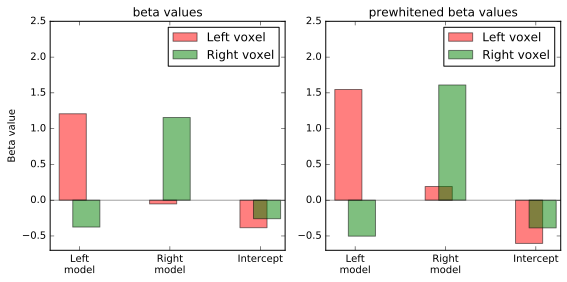

In [17]:
#
# Final step of the autocorrelation correction recipe:
# we perform the linear regression by means of matrix multiplication
#

proj_AR_1 = (np.matrix(design_matrix) * K_1 * np.matrix(design_matrix.T)).I * np.matrix(design_matrix)
betas_AR_1 = proj_AR_1 * K_1 * left_voxel_timecourse_Z.T

proj_AR_2 = (np.matrix(design_matrix) * K_2 * np.matrix(design_matrix.T)).I * np.matrix(design_matrix)
betas_AR_2 = proj_AR_2 * K_2 * right_voxel_timecourse_Z.T

AR_betas = np.array([betas_AR_1, betas_AR_2]).T[0]

# these matrices are not important enough to plot
# f = plt.figure(figsize = (10,4))
# s = plt.subplot(221)
# plt.title('Projection $(XX^T)$')
# plt.imshow((np.matrix(design_matrix) * np.matrix(design_matrix.T)), interpolation='nearest')
# s.set_xlabel('regressors')
# s.set_ylabel('regressors')
# plt.axis('off')
# plt.colorbar()
# s = plt.subplot(222)
# plt.title('Prewhitening Projection $(X\Sigma^{-1}X^T)$')
# plt.imshow((np.matrix(design_matrix) * K_2 * np.matrix(design_matrix.T)), interpolation='nearest')
# s.set_xlabel('regressors')
# s.set_ylabel('regressors')
# plt.axis('off')
# plt.colorbar()

# s = plt.subplot(223)
# plt.title('Projection $(XX^T)^{-1}$')
# plt.imshow((np.matrix(design_matrix) * np.matrix(design_matrix.T)).I, interpolation='nearest')
# s.set_xlabel('regressors')
# s.set_ylabel('regressors')
# plt.axis('off')
# plt.colorbar()
# s = plt.subplot(224)
# plt.title('Prewhitening Projection $(X\Sigma^{-1}X^T)^{-1}$')
# plt.imshow((np.matrix(design_matrix) * K_2 * np.matrix(design_matrix.T)).I, interpolation='nearest')
# s.set_xlabel('regressors')
# s.set_ylabel('regressors')
# plt.axis('off')
# plt.colorbar()

print 'uncorrected betas, left, right, intercept:'
print 'L Voxel    R Voxel'
print betas
print
print 'AR_corrected betas, left, right, intercept:'
print 'L Voxel    R Voxel'
print AR_betas

# again the plots are for advanced use.
# f = plt.figure(figsize = (10,4))
# s = plt.subplot(211)

# plt.title('uncorrected fMRI data')
# plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), left_voxel_timecourse_Z[0], 'r')
# plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), right_voxel_timecourse_Z[0], 'g--')
# plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

# s = plt.subplot(212)

# pwd_1, pwd_2 = (K_1 * left_voxel_timecourse_Z.T)[:,0], (K_2 * right_voxel_timecourse_Z.T)[:,0]

# plt.title('prewhitened fMRI data')
# plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), pwd_1, 'r')
# plt.plot(np.linspace(0,run_duration_in_sec, functional_data.shape[-1]), pwd_2, 'g--')
# plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
# plt.tight_layout()


# f = plt.figure(figsize = (10,3))
# s = f.add_subplot(121)

# plt.title('Lag-1 Autocorrelation after prewhitening')
# plt.plot(pwd_1[:-1], pwd_1[1:], 'ro', alpha = 0.25)
# plt.plot(pwd_2[:-1], pwd_2[1:], 'go', alpha = 0.25)
# plt.xlabel('Sample n')
# plt.ylabel('Sample n+1')
# plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
# plt.axvline(0, c = 'k', linewidth = 0.75, alpha = 0.5)


# s = f.add_subplot(122)

# plt.title('Lag-2 Autocorrelation after prewhitening')
# plt.plot(pwd_1[:-2], pwd_1[2:], 'ro', alpha = 0.25)
# plt.plot(pwd_2[:-2], pwd_2[2:], 'go', alpha = 0.25)
# plt.xlabel('Sample n')
# plt.ylabel('Sample n+2')
# plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
# plt.axvline(0, c = 'k', linewidth = 0.75, alpha = 0.5)
# plt.tight_layout()


fig = plt.figure(figsize = (8,4))
# first, a bar chart of the beta values
s = fig.add_subplot(121)

plt.title('beta values')
s.set_ylabel('Beta value')
plt.bar([0,1,2], betas[:,0], color = 'r', width = 0.3, alpha = 0.5)
plt.bar([0.15,1.15,2.15], betas[:,1], color = 'g',width = 0.3, alpha = 0.5)
plt.legend(['Left voxel', 'Right voxel'])
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

s.set_xticks([0.225,1.225,2.225])
s.set_xticklabels(['Left\nmodel', 'Right\nmodel', 'Intercept'])
s.set_xlim([-0.1,2.5])
s.set_ylim([-0.7,2.5])

s = fig.add_subplot(122)

plt.title('prewhitened beta values')

plt.bar([0,1,2], AR_betas[:,0], color = 'r', width = 0.3, alpha = 0.5)
plt.bar([0.15,1.15,2.15], AR_betas[:,1], color = 'g',width = 0.3, alpha = 0.5)
plt.legend(['Left voxel', 'Right voxel'])
plt.axhline(0, c = 'k', linewidth = 0.75, alpha = 0.5)

s.set_xticks([0.225,1.225,2.225])
s.set_xticklabels(['Left\nmodel', 'Right\nmodel', 'Intercept'])
s.set_xlim([-0.1,2.5])
s.set_ylim([-0.7,2.5])
plt.tight_layout()


### what to learn from this?
You notice that while the general pattern of results stays the same, there are definite changes in the exact beta values. Under the hood, the calculations performed by analysis packages such as FSL *do* incorporate these autocorrelation corrections, and you need to be aware of this fact.

*For the following, and the exercises, we will not perform prewhitening operations.*

# Statistics

## R-squared
Now, how do we go to statistical inference? 
For example, as a first step we might want to see how well our fit worked. To do this, we should relate the part of the data that we do explain, to the part that we don't explain. That means perhaps calculate the r-squared, i.e. the squared ratio of explained vs total variance.

In [18]:
r_squareds = 1.0 - np.sum((fitted_fmri_data - fmri_data)**2, axis = -1) / np.sum(fmri_data**2, axis = -1)
print 'r-squareds for the left and right voxels are: '
print 'L             R'
print r_squareds

r-squareds for the left and right voxels are: 
L             R
[ 0.54528677  0.61604852]


## T statistics & the p-value

But what we really want is to compare between conditions, which were coded in our design matrix as different regressors. The tests we'd need to do for this are t-tests between the conditions, and the calculations go as follows. First, we define a contrast vector, that codes for the exact comparison we want to make. For example, in the present situation, we'd like to test voxels for being more active for a left stimulus than for a right stimulus. The contrast vector becomes $C$ = **$[1, -1, 0]$**, because we are not interested in any difference involving the fitted intercept. An important rule here is, that when comparing conditions, the contrast vector should be 0 on average. We could also compare a single beta values against 0 (single t-test against 0), that's when we could create an unbalanced contrast vector of $C$ = **$[1, 0, 0]$**, for example.
To get the T-statistics we divide the beta values from the GLM by the standard error of the contrast, just like in a normal t-test. The calculation of the standard error of a contrast goes as follows: 

$$ SE = \sqrt{\frac{SSE}{df} \cdot C \cdot (X \cdot X^T)^{-1} \cdot C^T} $$

Here, $SSE$ is the `_sse` output of the `np.linalg.lstsq` function, the degrees of freedom $df$ is the amount of timepoints (450) minus the rank of $X$, the design matrix we also used for the GLM. The $(X \cdot X^T)^{-1}$ part serves to take into account the structure of the design matrix (do the regressors have very similar, or very different timecourses?) in the contrast.
Then the T-statistic is  

$$ T = \frac{C \cdot \beta}{SE} $$

and we can use this T-value to calculate the p-value for our contrast using the T-distribution and the degrees of freedom calculated above. 

See below for the actual calculation for our contrast in code, and the results. Make sure you understand the outcomes of the calculations as best you can before proceeding to the exercises, in which you will have to repeat these steps yourself.

In [19]:
# contrast vector and degrees of freedom
L_gt_R = np.matrix([-1,1,0])
design_matrix_rank = np.linalg.matrix_rank(design_matrix)
df = residuals.shape[-1] - design_matrix_rank

# some linear algebra, the C (XX^T)-1 CT part.
contrast_in_dm = np.array(L_gt_R * np.linalg.pinv(np.dot(design_matrix, design_matrix.T)) * L_gt_R.T).squeeze()

# to standard errors, using the mean, overall squared error, from the sum of squared residuals _sse
standard_errors = np.sqrt((_sse/df) * contrast_in_dm)

# T-statistics for the relevant regressors
T_stats = np.squeeze(np.array(np.dot(L_gt_R, betas) / standard_errors))

# and convert these to p-values using the T distribution:
from scipy.stats import t
p_vals = np.squeeze([t.cdf(-np.abs(x), df) for x in T_stats])

print '######## Statistics #########'
for p, t, s in zip(p_vals, T_stats, ['L','R']):
    print '%s: T-statistic: %2.4f, p-value is %1.5f' %(s,t,p)

######## Statistics #########
L: T-statistic: -19.6111, p-value is 0.00000
R: T-statistic: 25.9252, p-value is 0.00000


## Take Home:
What do you need to take home from this week's practical?
- What are $\beta$ values: scaling factors of explicit expectations we model (explanatory variable or regressor).
- We use the GLM to calculate these $\beta$ values, while assuming 
    - a certain shape of HRF
    - independent samples (0 autocorrelation) of the data
- These assumptions are not always met, so we have ways of correcting for errors in our assumptions:
    - we can flexibly fit the shape and timing of the HRF (*cf.* basis functions, time-derivative)
    - we can correct the GLM for autocorrelation of the timeseries (*cf.* Autocorrelation correction, prewhitening)
- To compare $\beta$ values we need to calculate statistics (T statistics), to see whether differences in $\beta$ values are significant (p values).